In [1]:
!nvidia-smi

!pip install torch torchvision tqdm

Fri Dec  5 04:18:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   58C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [3]:
IMG_DIR = "/content/drive/MyDrive/crowd_project/processed_images/processed_images"
DENSITY_DIR = "/content/drive/MyDrive/crowd_project/density_maps/density_maps"

In [12]:
transform = T.Compose([
    T.ToTensor(),  # Convert image to PyTorch tensor
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

In [5]:
class CrowdDataset(Dataset):
    def __init__(self, img_dir, density_dir, file_list, transform=None):
        self.img_dir = img_dir
        self.density_dir = density_dir
        self.files = file_list
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]

        img = cv2.imread(os.path.join(self.img_dir, img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform:
            img = self.transform(img)

        den = np.load(os.path.join(self.density_dir, img_name.replace(".jpg", ".npy")))
        den = cv2.resize(den, (den.shape[1]//8, den.shape[0]//8))
        den = den * 64

        den_tensor = torch.tensor(den, dtype=torch.float32).unsqueeze(0)

        return img, den_tensor


In [5]:
cfg = {
    'frontend': [64, 64, 'M',
                 128, 128, 'M',
                 256, 256, 256, 'M',
                 512, 512, 512],
    'backend': [512, 512, 512, 256, 128, 64]
}

def make_layers(cfg_list, in_channels=3, dilation=False):
    layers = []
    for v in cfg_list:
        if v == 'M':
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        else:
            if dilation:
                conv2d = nn.Conv2d(in_channels, v, 3, padding=2, dilation=2)
            else:
                conv2d = nn.Conv2d(in_channels, v, 3, padding=1)
            layers += [conv2d, nn.ReLU(True)]
            in_channels = v
    return nn.Sequential(*layers)

class CSRNet(nn.Module):
    def __init__(self):
        super(CSRNet, self).__init__()
        self.frontend = make_layers(cfg['frontend'], in_channels=3, dilation=False)
        self.backend = make_layers(cfg['backend'], in_channels=512, dilation=True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        x = torch.relu(x)   # ensure density >= 0
        return x


In [12]:
image_files = [f for f in os.listdir(IMG_DIR) if f.endswith(".jpg")]
train_files, val_files = train_test_split(image_files, test_size=0.17, random_state=42)

train_dataset = CrowdDataset(IMG_DIR, DENSITY_DIR, train_files, transform)
val_dataset = CrowdDataset(IMG_DIR, DENSITY_DIR, val_files, transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

print("Train:", len(train_dataset), "Validation:", len(val_dataset))


Train: 248 Validation: 52


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

model = CSRNet().to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)


Running on: cuda


In [14]:
num_epochs = 10

best_val_mae = float('inf')
best_model_path = "/content/drive/MyDrive/crowd_project/csrnet_best.pth"

for epoch in range(num_epochs):
    # -------- TRAINING --------
    model.train()
    train_loss = 0.0

    for imgs, dens in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Train"):
        imgs = imgs.to(device)
        dens = dens.to(device)

        outputs = model(imgs)
        loss = criterion(outputs, dens)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)

    train_loss /= len(train_dataset)

    # -------- VALIDATION --------
    model.eval()
    val_loss = 0.0
    val_mae = 0.0

    with torch.no_grad():
        for imgs, dens in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Val"):
            imgs = imgs.to(device)
            dens = dens.to(device)

            outputs = model(imgs)  # [B,1,H,W]
            loss = criterion(outputs, dens)
            val_loss += loss.item() * imgs.size(0)

            # ---- Count-based metric (MAE) ----
            # sum over H,W to get count per image
            gt_counts = dens.view(dens.size(0), -1).sum(dim=1)      # [B]
            pred_counts = outputs.view(outputs.size(0), -1).sum(dim=1)  # [B]

            val_mae += torch.abs(gt_counts - pred_counts).sum().item()

    val_loss /= len(val_dataset)
    val_mae /= len(val_dataset)

    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}")
    print(f"  Val MAE:    {val_mae:.2f} people")

    # -------- SAVE BEST MODEL --------
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        torch.save(model.state_dict(), best_model_path)
        print(f"  ✅ New best model saved (MAE = {best_val_mae:.2f})")
    else:
        print(f"  Best MAE so far: {best_val_mae:.2f}")


Epoch 1/10 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.27it/s]



Epoch 1/10
  Train Loss: 0.1348
  Val Loss:   0.1181
  Val MAE:    270.00 people
  ✅ New best model saved (MAE = 270.00)


Epoch 2/10 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.23it/s]



Epoch 2/10
  Train Loss: 0.1207
  Val Loss:   0.1152
  Val MAE:    296.64 people
  Best MAE so far: 270.00


Epoch 3/10 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.19it/s]



Epoch 3/10
  Train Loss: 0.1174
  Val Loss:   0.1113
  Val MAE:    292.77 people
  Best MAE so far: 270.00


Epoch 4/10 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.24it/s]



Epoch 4/10
  Train Loss: 0.1094
  Val Loss:   0.1011
  Val MAE:    286.62 people
  Best MAE so far: 270.00


Epoch 5/10 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.20it/s]



Epoch 5/10
  Train Loss: 0.0979
  Val Loss:   0.0952
  Val MAE:    275.79 people
  Best MAE so far: 270.00


Epoch 6/10 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.25it/s]



Epoch 6/10
  Train Loss: 0.0963
  Val Loss:   0.0936
  Val MAE:    235.85 people
  ✅ New best model saved (MAE = 235.85)


Epoch 7/10 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.04it/s]



Epoch 7/10
  Train Loss: 0.0966
  Val Loss:   0.1046
  Val MAE:    305.85 people
  Best MAE so far: 235.85


Epoch 8/10 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.07it/s]



Epoch 8/10
  Train Loss: 0.0937
  Val Loss:   0.0910
  Val MAE:    239.70 people
  Best MAE so far: 235.85


Epoch 9/10 - Val: 100%|██████████| 13/13 [00:03<00:00,  3.99it/s]



Epoch 9/10
  Train Loss: 0.0909
  Val Loss:   0.0940
  Val MAE:    241.48 people
  Best MAE so far: 235.85


Epoch 10/10 - Val: 100%|██████████| 13/13 [00:03<00:00,  3.99it/s]


Epoch 10/10
  Train Loss: 0.0896
  Val Loss:   0.0939
  Val MAE:    239.20 people
  Best MAE so far: 235.85


GT Count: 877.17957
Pred Count: 201.47714


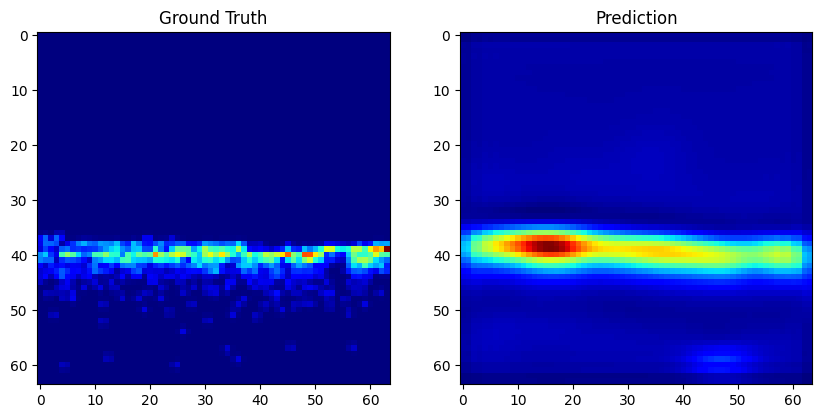

In [15]:
model.eval()
with torch.no_grad():
    imgs, dens = next(iter(val_loader))
    imgs = imgs.to(device)
    preds = model(imgs)

    gt = dens[0].cpu().numpy().squeeze()
    pr = preds[0].cpu().numpy().squeeze()

    print("GT Count:", gt.sum())
    print("Pred Count:", pr.sum())

    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    plt.imshow(gt, cmap='jet')
    plt.title("Ground Truth")

    plt.subplot(1,2,2)
    plt.imshow(pr, cmap='jet')
    plt.title("Prediction")
    plt.show()


In [16]:
num_epochs = 50

best_val_mae = float('inf')
best_model_path = "/content/drive/MyDrive/crowd_project/csrnet_best.pth"

for epoch in range(num_epochs):
    # -------- TRAINING --------
    model.train()
    train_loss = 0.0

    for imgs, dens in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Train"):
        imgs = imgs.to(device)
        dens = dens.to(device)

        outputs = model(imgs)
        loss = criterion(outputs, dens)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)

    train_loss /= len(train_dataset)

    # -------- VALIDATION --------
    model.eval()
    val_loss = 0.0
    val_mae = 0.0

    with torch.no_grad():
        for imgs, dens in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Val"):
            imgs = imgs.to(device)
            dens = dens.to(device)

            outputs = model(imgs)  # [B,1,H,W]
            loss = criterion(outputs, dens)
            val_loss += loss.item() * imgs.size(0)

            # ---- Count-based metric (MAE) ----
            # sum over H,W to get count per image
            gt_counts = dens.view(dens.size(0), -1).sum(dim=1)      # [B]
            pred_counts = outputs.view(outputs.size(0), -1).sum(dim=1)  # [B]

            val_mae += torch.abs(gt_counts - pred_counts).sum().item()

    val_loss /= len(val_dataset)
    val_mae /= len(val_dataset)

    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}")
    print(f"  Val MAE:    {val_mae:.2f} people")

    # -------- SAVE BEST MODEL --------
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        torch.save(model.state_dict(), best_model_path)
        print(f"  ✅ New best model saved (MAE = {best_val_mae:.2f})")
    else:
        print(f"  Best MAE so far: {best_val_mae:.2f}")


Epoch 1/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.17it/s]



Epoch 1/50
  Train Loss: 0.0861
  Val Loss:   0.0884
  Val MAE:    233.61 people
  ✅ New best model saved (MAE = 233.61)


Epoch 2/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.21it/s]



Epoch 2/50
  Train Loss: 0.0832
  Val Loss:   0.0936
  Val MAE:    311.01 people
  Best MAE so far: 233.61


Epoch 3/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.23it/s]



Epoch 3/50
  Train Loss: 0.0943
  Val Loss:   0.0892
  Val MAE:    226.94 people
  ✅ New best model saved (MAE = 226.94)


Epoch 4/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.22it/s]



Epoch 4/50
  Train Loss: 0.0853
  Val Loss:   0.0900
  Val MAE:    298.93 people
  Best MAE so far: 226.94


Epoch 5/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.21it/s]



Epoch 5/50
  Train Loss: 0.0829
  Val Loss:   0.0852
  Val MAE:    231.92 people
  Best MAE so far: 226.94


Epoch 6/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.17it/s]



Epoch 6/50
  Train Loss: 0.0803
  Val Loss:   0.0846
  Val MAE:    224.65 people
  ✅ New best model saved (MAE = 224.65)


Epoch 7/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.17it/s]



Epoch 7/50
  Train Loss: 0.0786
  Val Loss:   0.0873
  Val MAE:    291.37 people
  Best MAE so far: 224.65


Epoch 8/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.10it/s]



Epoch 8/50
  Train Loss: 0.0782
  Val Loss:   0.0891
  Val MAE:    344.72 people
  Best MAE so far: 224.65


Epoch 9/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  3.99it/s]



Epoch 9/50
  Train Loss: 0.0800
  Val Loss:   0.0850
  Val MAE:    297.04 people
  Best MAE so far: 224.65


Epoch 10/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.02it/s]



Epoch 10/50
  Train Loss: 0.0787
  Val Loss:   0.0806
  Val MAE:    227.08 people
  Best MAE so far: 224.65


Epoch 11/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.03it/s]



Epoch 11/50
  Train Loss: 0.0733
  Val Loss:   0.0811
  Val MAE:    229.46 people
  Best MAE so far: 224.65


Epoch 12/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.06it/s]



Epoch 12/50
  Train Loss: 0.0812
  Val Loss:   0.0918
  Val MAE:    293.35 people
  Best MAE so far: 224.65


Epoch 13/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.12it/s]



Epoch 13/50
  Train Loss: 0.0754
  Val Loss:   0.0804
  Val MAE:    230.82 people
  Best MAE so far: 224.65


Epoch 14/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.15it/s]



Epoch 14/50
  Train Loss: 0.0725
  Val Loss:   0.0784
  Val MAE:    227.82 people
  Best MAE so far: 224.65


Epoch 15/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.21it/s]



Epoch 15/50
  Train Loss: 0.0756
  Val Loss:   0.0948
  Val MAE:    300.82 people
  Best MAE so far: 224.65


Epoch 16/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.14it/s]



Epoch 16/50
  Train Loss: 0.0725
  Val Loss:   0.0774
  Val MAE:    229.00 people
  Best MAE so far: 224.65


Epoch 17/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.21it/s]



Epoch 17/50
  Train Loss: 0.0691
  Val Loss:   0.1043
  Val MAE:    320.06 people
  Best MAE so far: 224.65


Epoch 18/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.21it/s]



Epoch 18/50
  Train Loss: 0.0752
  Val Loss:   0.0848
  Val MAE:    286.82 people
  Best MAE so far: 224.65


Epoch 19/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.19it/s]



Epoch 19/50
  Train Loss: 0.0731
  Val Loss:   0.0757
  Val MAE:    296.06 people
  Best MAE so far: 224.65


Epoch 20/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.18it/s]



Epoch 20/50
  Train Loss: 0.0696
  Val Loss:   0.0755
  Val MAE:    224.33 people
  ✅ New best model saved (MAE = 224.33)


Epoch 21/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.18it/s]



Epoch 21/50
  Train Loss: 0.0784
  Val Loss:   0.0818
  Val MAE:    230.34 people
  Best MAE so far: 224.33


Epoch 22/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.13it/s]



Epoch 22/50
  Train Loss: 0.0681
  Val Loss:   0.0739
  Val MAE:    253.70 people
  Best MAE so far: 224.33


Epoch 23/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.09it/s]



Epoch 23/50
  Train Loss: 0.0689
  Val Loss:   0.0765
  Val MAE:    243.67 people
  Best MAE so far: 224.33


Epoch 24/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  3.98it/s]



Epoch 24/50
  Train Loss: 0.0703
  Val Loss:   0.0883
  Val MAE:    265.77 people
  Best MAE so far: 224.33


Epoch 25/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.04it/s]



Epoch 25/50
  Train Loss: 0.0678
  Val Loss:   0.0794
  Val MAE:    240.60 people
  Best MAE so far: 224.33


Epoch 26/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.09it/s]



Epoch 26/50
  Train Loss: 0.0710
  Val Loss:   0.0748
  Val MAE:    212.89 people
  ✅ New best model saved (MAE = 212.89)


Epoch 27/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.20it/s]



Epoch 27/50
  Train Loss: 0.0657
  Val Loss:   0.0755
  Val MAE:    305.46 people
  Best MAE so far: 212.89


Epoch 28/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.20it/s]



Epoch 28/50
  Train Loss: 0.0667
  Val Loss:   0.0731
  Val MAE:    211.82 people
  ✅ New best model saved (MAE = 211.82)


Epoch 29/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.19it/s]



Epoch 29/50
  Train Loss: 0.0646
  Val Loss:   0.0859
  Val MAE:    285.92 people
  Best MAE so far: 211.82


Epoch 30/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.19it/s]



Epoch 30/50
  Train Loss: 0.0653
  Val Loss:   0.0832
  Val MAE:    284.19 people
  Best MAE so far: 211.82


Epoch 31/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.21it/s]



Epoch 31/50
  Train Loss: 0.0778
  Val Loss:   0.0763
  Val MAE:    219.05 people
  Best MAE so far: 211.82


Epoch 32/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.21it/s]



Epoch 32/50
  Train Loss: 0.0665
  Val Loss:   0.0863
  Val MAE:    242.07 people
  Best MAE so far: 211.82


Epoch 33/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.21it/s]



Epoch 33/50
  Train Loss: 0.0629
  Val Loss:   0.0746
  Val MAE:    215.14 people
  Best MAE so far: 211.82


Epoch 34/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.16it/s]



Epoch 34/50
  Train Loss: 0.0619
  Val Loss:   0.0706
  Val MAE:    235.89 people
  Best MAE so far: 211.82


Epoch 35/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.05it/s]



Epoch 35/50
  Train Loss: 0.0598
  Val Loss:   0.0757
  Val MAE:    228.71 people
  Best MAE so far: 211.82


Epoch 36/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.02it/s]



Epoch 36/50
  Train Loss: 0.0649
  Val Loss:   0.0934
  Val MAE:    273.21 people
  Best MAE so far: 211.82


Epoch 37/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  3.94it/s]



Epoch 37/50
  Train Loss: 0.0649
  Val Loss:   0.0726
  Val MAE:    249.04 people
  Best MAE so far: 211.82


Epoch 38/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.09it/s]



Epoch 38/50
  Train Loss: 0.0640
  Val Loss:   0.0718
  Val MAE:    227.20 people
  Best MAE so far: 211.82


Epoch 39/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.12it/s]



Epoch 39/50
  Train Loss: 0.0617
  Val Loss:   0.0776
  Val MAE:    220.75 people
  Best MAE so far: 211.82


Epoch 40/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.19it/s]



Epoch 40/50
  Train Loss: 0.0622
  Val Loss:   0.0786
  Val MAE:    233.81 people
  Best MAE so far: 211.82


Epoch 41/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.20it/s]



Epoch 41/50
  Train Loss: 0.0655
  Val Loss:   0.0757
  Val MAE:    278.82 people
  Best MAE so far: 211.82


Epoch 42/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.22it/s]



Epoch 42/50
  Train Loss: 0.0611
  Val Loss:   0.0732
  Val MAE:    211.32 people
  ✅ New best model saved (MAE = 211.32)


Epoch 43/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.23it/s]



Epoch 43/50
  Train Loss: 0.0592
  Val Loss:   0.0808
  Val MAE:    208.81 people
  ✅ New best model saved (MAE = 208.81)


Epoch 44/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.17it/s]



Epoch 44/50
  Train Loss: 0.0581
  Val Loss:   0.0697
  Val MAE:    204.20 people
  ✅ New best model saved (MAE = 204.20)


Epoch 45/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.05it/s]



Epoch 45/50
  Train Loss: 0.0617
  Val Loss:   0.0819
  Val MAE:    307.23 people
  Best MAE so far: 204.20


Epoch 46/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.10it/s]



Epoch 46/50
  Train Loss: 0.0658
  Val Loss:   0.0725
  Val MAE:    252.10 people
  Best MAE so far: 204.20


Epoch 47/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.07it/s]



Epoch 47/50
  Train Loss: 0.0615
  Val Loss:   0.0767
  Val MAE:    223.18 people
  Best MAE so far: 204.20


Epoch 48/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  3.96it/s]



Epoch 48/50
  Train Loss: 0.0594
  Val Loss:   0.0735
  Val MAE:    217.84 people
  Best MAE so far: 204.20


Epoch 49/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  3.99it/s]



Epoch 49/50
  Train Loss: 0.0562
  Val Loss:   0.0721
  Val MAE:    218.47 people
  Best MAE so far: 204.20


Epoch 50/50 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.11it/s]


Epoch 50/50
  Train Loss: 0.0596
  Val Loss:   0.0701
  Val MAE:    205.27 people
  Best MAE so far: 204.20


GT Count: 877.17957
Pred Count: 306.7196


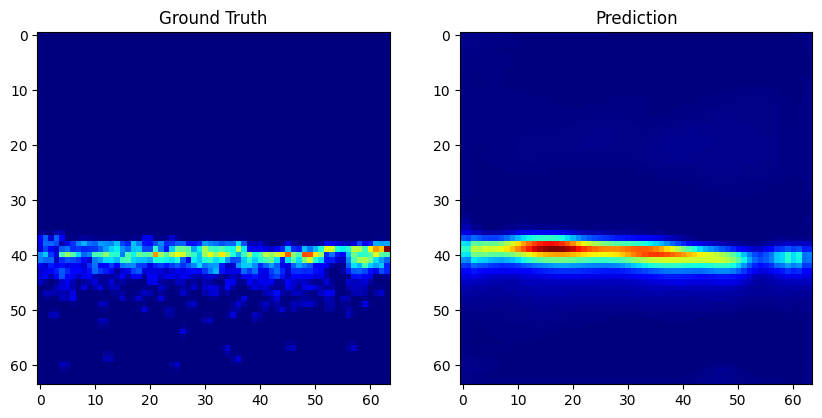

In [17]:
model.eval()
with torch.no_grad():
    imgs, dens = next(iter(val_loader))
    imgs = imgs.to(device)
    preds = model(imgs)

    gt = dens[0].cpu().numpy().squeeze()
    pr = preds[0].cpu().numpy().squeeze()

    print("GT Count:", gt.sum())
    print("Pred Count:", pr.sum())

    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    plt.imshow(gt, cmap='jet')
    plt.title("Ground Truth")

    plt.subplot(1,2,2)
    plt.imshow(pr, cmap='jet')
    plt.title("Prediction")
    plt.show()


In [ ]:
num_epochs = 100

best_val_mae = float('inf')
best_model_path = "/content/drive/MyDrive/crowd_project/csrnet_best.pth"

for epoch in range(num_epochs):
    # -------- TRAINING --------
    model.train()
    train_loss = 0.0

    for imgs, dens in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Train"):
        imgs = imgs.to(device)
        dens = dens.to(device)

        outputs = model(imgs)
        loss = criterion(outputs, dens)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)

    train_loss /= len(train_dataset)

    # -------- VALIDATION --------
    model.eval()
    val_loss = 0.0
    val_mae = 0.0

    with torch.no_grad():
        for imgs, dens in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Val"):
            imgs = imgs.to(device)
            dens = dens.to(device)

            outputs = model(imgs)  # [B,1,H,W]
            loss = criterion(outputs, dens)
            val_loss += loss.item() * imgs.size(0)

            # ---- Count-based metric (MAE) ----
            # sum over H,W to get count per image
            gt_counts = dens.view(dens.size(0), -1).sum(dim=1)      # [B]
            pred_counts = outputs.view(outputs.size(0), -1).sum(dim=1)  # [B]

            val_mae += torch.abs(gt_counts - pred_counts).sum().item()

    val_loss /= len(val_dataset)
    val_mae /= len(val_dataset)

    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}")
    print(f"  Val MAE:    {val_mae:.2f} people")

    # -------- SAVE BEST MODEL --------
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        torch.save(model.state_dict(), best_model_path)
        print(f"  ✅ New best model saved (MAE = {best_val_mae:.2f})")
    else:
        print(f"  Best MAE so far: {best_val_mae:.2f}")


Epoch 1/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.15it/s]



Epoch 1/100
  Train Loss: 0.0573
  Val Loss:   0.0760
  Val MAE:    218.15 people
  ✅ New best model saved (MAE = 218.15)


Epoch 2/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.23it/s]



Epoch 2/100
  Train Loss: 0.0591
  Val Loss:   0.0757
  Val MAE:    199.61 people
  ✅ New best model saved (MAE = 199.61)


Epoch 3/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.16it/s]



Epoch 3/100
  Train Loss: 0.0565
  Val Loss:   0.0719
  Val MAE:    196.83 people
  ✅ New best model saved (MAE = 196.83)


Epoch 4/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.22it/s]



Epoch 4/100
  Train Loss: 0.0565
  Val Loss:   0.0696
  Val MAE:    225.78 people
  Best MAE so far: 196.83


Epoch 5/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.20it/s]



Epoch 5/100
  Train Loss: 0.0569
  Val Loss:   0.0763
  Val MAE:    208.28 people
  Best MAE so far: 196.83


Epoch 6/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.18it/s]



Epoch 6/100
  Train Loss: 0.0597
  Val Loss:   0.0716
  Val MAE:    209.71 people
  Best MAE so far: 196.83


Epoch 7/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.16it/s]



Epoch 7/100
  Train Loss: 0.0550
  Val Loss:   0.0723
  Val MAE:    233.18 people
  Best MAE so far: 196.83


Epoch 8/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.07it/s]



Epoch 8/100
  Train Loss: 0.0562
  Val Loss:   0.0716
  Val MAE:    208.79 people
  Best MAE so far: 196.83


Epoch 9/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.00it/s]



Epoch 9/100
  Train Loss: 0.0623
  Val Loss:   0.0762
  Val MAE:    295.68 people
  Best MAE so far: 196.83


Epoch 10/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.00it/s]



Epoch 10/100
  Train Loss: 0.0595
  Val Loss:   0.0713
  Val MAE:    198.85 people
  Best MAE so far: 196.83


Epoch 11/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.01it/s]



Epoch 11/100
  Train Loss: 0.0525
  Val Loss:   0.0690
  Val MAE:    186.71 people
  ✅ New best model saved (MAE = 186.71)


Epoch 12/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.24it/s]



Epoch 12/100
  Train Loss: 0.0570
  Val Loss:   0.0755
  Val MAE:    234.39 people
  Best MAE so far: 186.71


Epoch 13/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.21it/s]



Epoch 13/100
  Train Loss: 0.0559
  Val Loss:   0.0658
  Val MAE:    193.67 people
  Best MAE so far: 186.71


Epoch 14/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.23it/s]



Epoch 14/100
  Train Loss: 0.0554
  Val Loss:   0.0718
  Val MAE:    248.68 people
  Best MAE so far: 186.71


Epoch 15/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.19it/s]



Epoch 15/100
  Train Loss: 0.0534
  Val Loss:   0.0686
  Val MAE:    218.89 people
  Best MAE so far: 186.71


Epoch 16/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.22it/s]



Epoch 16/100
  Train Loss: 0.0529
  Val Loss:   0.0678
  Val MAE:    200.05 people
  Best MAE so far: 186.71


Epoch 17/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.24it/s]



Epoch 17/100
  Train Loss: 0.0608
  Val Loss:   0.0795
  Val MAE:    231.06 people
  Best MAE so far: 186.71


Epoch 18/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.22it/s]



Epoch 18/100
  Train Loss: 0.0541
  Val Loss:   0.0785
  Val MAE:    266.84 people
  Best MAE so far: 186.71


Epoch 19/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.20it/s]



Epoch 19/100
  Train Loss: 0.0563
  Val Loss:   0.0695
  Val MAE:    210.53 people
  Best MAE so far: 186.71


Epoch 20/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.24it/s]



Epoch 20/100
  Train Loss: 0.0523
  Val Loss:   0.0690
  Val MAE:    195.33 people
  Best MAE so far: 186.71


Epoch 21/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.26it/s]



Epoch 21/100
  Train Loss: 0.0560
  Val Loss:   0.0730
  Val MAE:    219.48 people
  Best MAE so far: 186.71


Epoch 22/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.23it/s]



Epoch 22/100
  Train Loss: 0.0511
  Val Loss:   0.0679
  Val MAE:    187.02 people
  Best MAE so far: 186.71


Epoch 23/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.14it/s]



Epoch 23/100
  Train Loss: 0.0513
  Val Loss:   0.0664
  Val MAE:    184.03 people
  ✅ New best model saved (MAE = 184.03)


Epoch 24/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.11it/s]



Epoch 24/100
  Train Loss: 0.0504
  Val Loss:   0.0671
  Val MAE:    182.04 people
  ✅ New best model saved (MAE = 182.04)


Epoch 25/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.08it/s]



Epoch 25/100
  Train Loss: 0.0531
  Val Loss:   0.0687
  Val MAE:    190.37 people
  Best MAE so far: 182.04


Epoch 26/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.14it/s]



Epoch 26/100
  Train Loss: 0.0523
  Val Loss:   0.0692
  Val MAE:    194.50 people
  Best MAE so far: 182.04


Epoch 27/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.21it/s]



Epoch 27/100
  Train Loss: 0.0498
  Val Loss:   0.0688
  Val MAE:    191.56 people
  Best MAE so far: 182.04


Epoch 28/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.23it/s]



Epoch 28/100
  Train Loss: 0.0513
  Val Loss:   0.0720
  Val MAE:    318.93 people
  Best MAE so far: 182.04


Epoch 29/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.19it/s]



Epoch 29/100
  Train Loss: 0.0531
  Val Loss:   0.0682
  Val MAE:    231.67 people
  Best MAE so far: 182.04


Epoch 30/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.21it/s]



Epoch 30/100
  Train Loss: 0.0499
  Val Loss:   0.0691
  Val MAE:    188.97 people
  Best MAE so far: 182.04


Epoch 31/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.24it/s]



Epoch 31/100
  Train Loss: 0.0486
  Val Loss:   0.0683
  Val MAE:    188.00 people
  Best MAE so far: 182.04


Epoch 32/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.22it/s]



Epoch 32/100
  Train Loss: 0.0524
  Val Loss:   0.0744
  Val MAE:    252.83 people
  Best MAE so far: 182.04


Epoch 33/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.21it/s]



Epoch 33/100
  Train Loss: 0.0531
  Val Loss:   0.0718
  Val MAE:    231.44 people
  Best MAE so far: 182.04


Epoch 34/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.20it/s]



Epoch 34/100
  Train Loss: 0.0531
  Val Loss:   0.0650
  Val MAE:    195.95 people
  Best MAE so far: 182.04


Epoch 35/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.24it/s]



Epoch 35/100
  Train Loss: 0.0482
  Val Loss:   0.0685
  Val MAE:    178.73 people
  ✅ New best model saved (MAE = 178.73)


Epoch 36/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.05it/s]



Epoch 36/100
  Train Loss: 0.0499
  Val Loss:   0.0671
  Val MAE:    183.39 people
  Best MAE so far: 178.73


Epoch 37/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.06it/s]



Epoch 37/100
  Train Loss: 0.0553
  Val Loss:   0.0769
  Val MAE:    198.78 people
  Best MAE so far: 178.73


Epoch 38/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  3.95it/s]



Epoch 38/100
  Train Loss: 0.0520
  Val Loss:   0.0686
  Val MAE:    186.54 people
  Best MAE so far: 178.73


Epoch 39/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.02it/s]



Epoch 39/100
  Train Loss: 0.0487
  Val Loss:   0.0882
  Val MAE:    254.98 people
  Best MAE so far: 178.73


Epoch 40/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.03it/s]



Epoch 40/100
  Train Loss: 0.0539
  Val Loss:   0.0679
  Val MAE:    184.32 people
  Best MAE so far: 178.73


Epoch 41/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.13it/s]



Epoch 41/100
  Train Loss: 0.0481
  Val Loss:   0.0677
  Val MAE:    194.84 people
  Best MAE so far: 178.73


Epoch 42/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.14it/s]



Epoch 42/100
  Train Loss: 0.0483
  Val Loss:   0.0701
  Val MAE:    178.25 people
  ✅ New best model saved (MAE = 178.25)


Epoch 43/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.24it/s]



Epoch 43/100
  Train Loss: 0.0484
  Val Loss:   0.0686
  Val MAE:    180.66 people
  Best MAE so far: 178.25


Epoch 44/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.20it/s]



Epoch 44/100
  Train Loss: 0.0521
  Val Loss:   0.0745
  Val MAE:    247.46 people
  Best MAE so far: 178.25


Epoch 45/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.22it/s]



Epoch 45/100
  Train Loss: 0.0529
  Val Loss:   0.0668
  Val MAE:    189.07 people
  Best MAE so far: 178.25


Epoch 46/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.19it/s]



Epoch 46/100
  Train Loss: 0.0485
  Val Loss:   0.0679
  Val MAE:    186.22 people
  Best MAE so far: 178.25


Epoch 47/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.22it/s]



Epoch 47/100
  Train Loss: 0.0465
  Val Loss:   0.0652
  Val MAE:    175.48 people
  ✅ New best model saved (MAE = 175.48)


Epoch 48/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.22it/s]



Epoch 48/100
  Train Loss: 0.0455
  Val Loss:   0.0656
  Val MAE:    193.10 people
  Best MAE so far: 175.48


Epoch 49/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.16it/s]



Epoch 49/100
  Train Loss: 0.0472
  Val Loss:   0.0671
  Val MAE:    186.91 people
  Best MAE so far: 175.48


Epoch 50/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.11it/s]



Epoch 50/100
  Train Loss: 0.0525
  Val Loss:   0.0819
  Val MAE:    224.85 people
  Best MAE so far: 175.48


Epoch 51/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.04it/s]



Epoch 51/100
  Train Loss: 0.0510
  Val Loss:   0.0663
  Val MAE:    187.87 people
  Best MAE so far: 175.48


Epoch 52/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.06it/s]



Epoch 52/100
  Train Loss: 0.0479
  Val Loss:   0.0674
  Val MAE:    197.10 people
  Best MAE so far: 175.48


Epoch 53/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.00it/s]



Epoch 53/100
  Train Loss: 0.0451
  Val Loss:   0.0671
  Val MAE:    176.34 people
  Best MAE so far: 175.48


Epoch 54/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.03it/s]



Epoch 54/100
  Train Loss: 0.0488
  Val Loss:   0.0723
  Val MAE:    209.90 people
  Best MAE so far: 175.48


Epoch 55/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.12it/s]



Epoch 55/100
  Train Loss: 0.0488
  Val Loss:   0.0652
  Val MAE:    181.62 people
  Best MAE so far: 175.48


Epoch 56/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.15it/s]



Epoch 56/100
  Train Loss: 0.0473
  Val Loss:   0.0669
  Val MAE:    204.92 people
  Best MAE so far: 175.48


Epoch 57/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.16it/s]



Epoch 57/100
  Train Loss: 0.0473
  Val Loss:   0.0740
  Val MAE:    249.03 people
  Best MAE so far: 175.48


Epoch 58/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.20it/s]



Epoch 58/100
  Train Loss: 0.0476
  Val Loss:   0.0658
  Val MAE:    175.36 people
  ✅ New best model saved (MAE = 175.36)


Epoch 59/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.21it/s]



Epoch 59/100
  Train Loss: 0.0446
  Val Loss:   0.0645
  Val MAE:    180.38 people
  Best MAE so far: 175.36


Epoch 60/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.23it/s]



Epoch 60/100
  Train Loss: 0.0469
  Val Loss:   0.0723
  Val MAE:    191.10 people
  Best MAE so far: 175.36


Epoch 61/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.23it/s]



Epoch 61/100
  Train Loss: 0.0465
  Val Loss:   0.0637
  Val MAE:    174.58 people
  ✅ New best model saved (MAE = 174.58)


Epoch 62/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.22it/s]



Epoch 62/100
  Train Loss: 0.0455
  Val Loss:   0.0692
  Val MAE:    269.84 people
  Best MAE so far: 174.58


Epoch 63/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.22it/s]



Epoch 63/100
  Train Loss: 0.0496
  Val Loss:   0.0683
  Val MAE:    219.94 people
  Best MAE so far: 174.58


Epoch 64/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.17it/s]



Epoch 64/100
  Train Loss: 0.0454
  Val Loss:   0.0663
  Val MAE:    211.06 people
  Best MAE so far: 174.58


Epoch 65/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.13it/s]



Epoch 65/100
  Train Loss: 0.0459
  Val Loss:   0.0798
  Val MAE:    302.05 people
  Best MAE so far: 174.58


Epoch 66/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.06it/s]



Epoch 66/100
  Train Loss: 0.0473
  Val Loss:   0.0729
  Val MAE:    205.18 people
  Best MAE so far: 174.58


Epoch 67/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.00it/s]



Epoch 67/100
  Train Loss: 0.0462
  Val Loss:   0.0651
  Val MAE:    170.03 people
  ✅ New best model saved (MAE = 170.03)


Epoch 68/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.15it/s]



Epoch 68/100
  Train Loss: 0.0454
  Val Loss:   0.0699
  Val MAE:    251.31 people
  Best MAE so far: 170.03


Epoch 69/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.21it/s]



Epoch 69/100
  Train Loss: 0.0439
  Val Loss:   0.0657
  Val MAE:    188.22 people
  Best MAE so far: 170.03


Epoch 70/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.23it/s]



Epoch 70/100
  Train Loss: 0.0427
  Val Loss:   0.0687
  Val MAE:    174.18 people
  Best MAE so far: 170.03


Epoch 71/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.23it/s]



Epoch 71/100
  Train Loss: 0.0450
  Val Loss:   0.0669
  Val MAE:    172.09 people
  Best MAE so far: 170.03


Epoch 72/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.22it/s]



Epoch 72/100
  Train Loss: 0.0433
  Val Loss:   0.0657
  Val MAE:    176.01 people
  Best MAE so far: 170.03


Epoch 73/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.18it/s]



Epoch 73/100
  Train Loss: 0.0424
  Val Loss:   0.0671
  Val MAE:    194.54 people
  Best MAE so far: 170.03


Epoch 74/100 - Val: 100%|██████████| 13/13 [00:03<00:00,  4.25it/s]



Epoch 74/100
  Train Loss: 0.0413
  Val Loss:   0.0693
  Val MAE:    188.26 people
  Best MAE so far: 170.03


Epoch 75/100 - Train:  10%|▉         | 6/62 [00:03<00:32,  1.71it/s]

In [1]:
model.eval()
with torch.no_grad():
    imgs, dens = next(iter(val_loader))
    imgs = imgs.to(device)
    preds = model(imgs)

    gt = dens[0].cpu().numpy().squeeze()
    pr = preds[0].cpu().numpy().squeeze()

    print("GT Count:", gt.sum())
    print("Pred Count:", pr.sum())

    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    plt.imshow(gt, cmap='jet')
    plt.title("Ground Truth")

    plt.subplot(1,2,2)
    plt.imshow(pr, cmap='jet')
    plt.title("Prediction")
    plt.show()


NameError: name 'model' is not defined

In [7]:
model_path = "/content/drive/MyDrive/crowd_project/csrnet_best.pth"  # change if needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CSRNet().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print("Loaded model!")

Loaded model!


In [13]:
test_img_name = "IMG_9.jpg"  # update to your processed test image file

img_path = f"/content/drive/MyDrive/crowd_project/{test_img_name}"

# Load processed image (RGB)
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Keep copy for displaying heatmap overlays
img_display = img.copy()

# Convert to tensor with same transforms used in training
img_tensor = transform(img)
img_tensor = img_tensor.unsqueeze(0).to(device)  # shape: [1,3,H,W]

In [16]:
model.eval()
with torch.no_grad():
    pred = model(img_tensor)

pred = pred.cpu().numpy().squeeze()  # shape -> (64, 64)
pred_count = pred.sum()

print(f"Predicted Count: {pred_count:.2f}")

Predicted Count: 468.76


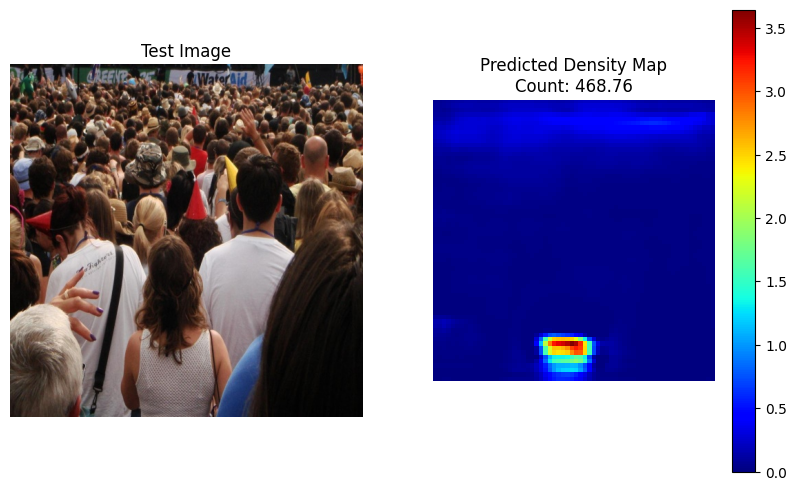

In [17]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(img_display)
plt.title("Test Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(pred, cmap="jet")
plt.title(f"Predicted Density Map\nCount: {pred_count:.2f}")
plt.colorbar()
plt.axis("off")
plt.show()